# ADD TITLE

#### Introduction
<br>
&nbsp; A research team at UBC wants to collect data about how people play video games. To do this, they plan to recruit participants to play Minecraft on a recorded server, which will allow them to observe player actions and interactions. They wish to target their recruitment efforts to maximize the amount of data they can collect. 
<br>
<br>
&nbsp; We utilized data collected by the reasearch team to identify which kinds of players are most likely to contribute large amounts of data so that those players can be targeted in recruiting efforts. Specifically, we aimed to determine whether or not we can estimate the total playing time a participant will contribute based on their age and previous playing experience. The research team provided 2 datasets: players.csv and sessions.csv, which we will refer to as the Players Dataset and the Sessions Dataset. The Players Dataset contains 196 observations and the following 9 variables: experience, subscribe, hashedEmail, played_hours, name, gender, age, individualID, and organizationName. The Sessions Dataset contains 1535 observations and the following 5 variables: hashedEmail, start_time, end_time, original_start_time, and original_end_time. All variables and potential issues with the data are described in the tables below. We only looked at the experience, age, and played_hours variables in the Players Dataset to address our question. 
<br>
<br>

##### **Table 1: Variable Descriptions**

| Variable Name | Variable Type | Meaning |
|---------------|---------------|---------|
|experience|character|players experience level|
|subscribe|logical|whether or not player is subscribed to email updates|
|hashedEmail|character|players encrypted email address|
|played_hours|double|total hours of play time contributed|
|name|character|players name|
|gender|character|players gender|
|age|double|players age|
|individualID|logical|assumed to be a string of numbers and/or letters assigned to player for identification|
|organizationName|logical|assumed to be name of the group that was asked to participate which player is part of|
|start_time|character|start date and time of playing session|
|end_time|character|end date and time of playing session|
|original_start_time|double|start time of playing session in unix timestamp format|
|original_end_time|double|end time of playing session in unix timestamp format|
<br>
<br>

##### **Table 2: Issues with Data**

| Data Table | Issue |
|------------|-------|
|Players Dataset|individualID and organizationName columns provide no information|
|Players Dataset|experience and gender should be factors because they are categorical|
|Players Dataset|some variables don’t contain equal amounts of each type (eg. there are more males than any other gender, etc.)|
|Sessions Dataset|multiple observations with the same hashedEmail, may affect whether/how observations are grouped later on for analysis|
|Sessions Dataset|start_time and end_time columns should be datetime, not character|
|Sessions Dataset|all observations for original_start_time and original_end_time are the same because they are in unix timestamp format and the values are too large, are not providing valuable information|
|Both|data is in 2 data frames, should be in 1|
|Both|sessions data has more observations than players data, may be an issue when merging data sets if one has more unique hashed emails than the other|

#### Methods and Results

In [ ]:
#### 

In [61]:
library(tidyverse)
library(tidymodels)
library(dplyr)
url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
data <- read_csv(url)
head(data)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [62]:
full_unedited <- data |>
                select(experience, played_hours, age) |>
                mutate(experience = recode(experience,
                            Pro = "5",
                            Veteran = '4',
                            Regular = '3',
                            Beginner = '2',
                            Amateur = '1'), 
                            experience = as.numeric(experience))

#changing experience levels to numerical values  
head(full_unedited)

experience,played_hours,age
<dbl>,<dbl>,<dbl>
5,30.3,9
4,3.8,17
4,0.0,17
1,0.7,21
3,0.1,21
1,0.0,17


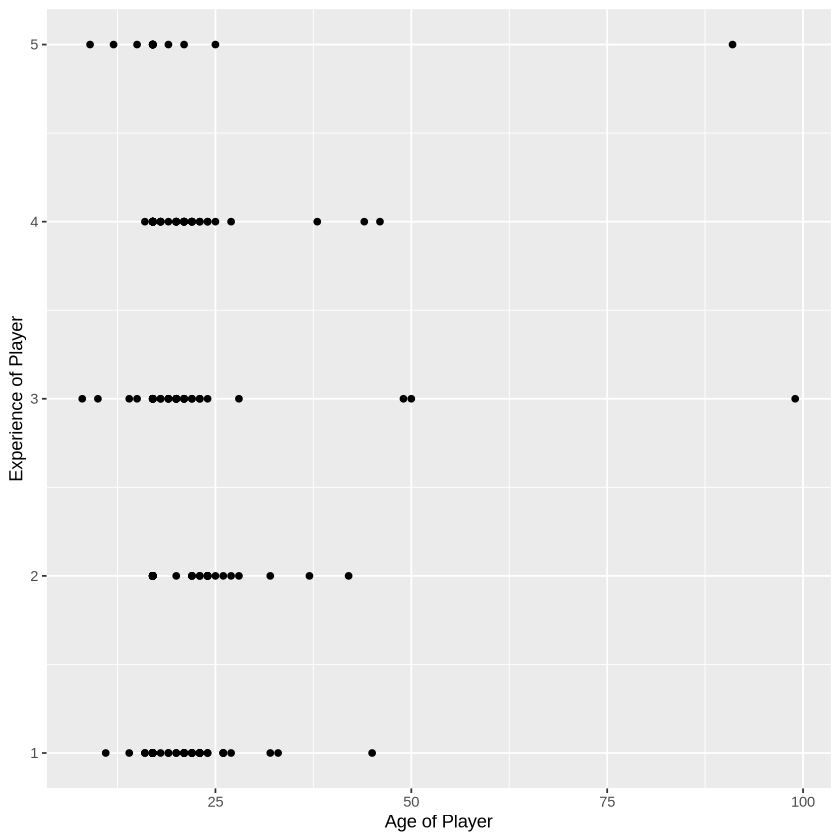

In [63]:
plot <- full_unedited |>
        ggplot(aes(x = age, y = experience)) +
        geom_point() +
        xlab("Age of Player") +
        ylab("Experience of Player")
plot

In [64]:
set.seed(2024)
split <- initial_split(full_unedited, prop = 0.70, strata = played_hours)
training <- training(split)
testing <- testing(split) 
#splitting the data!

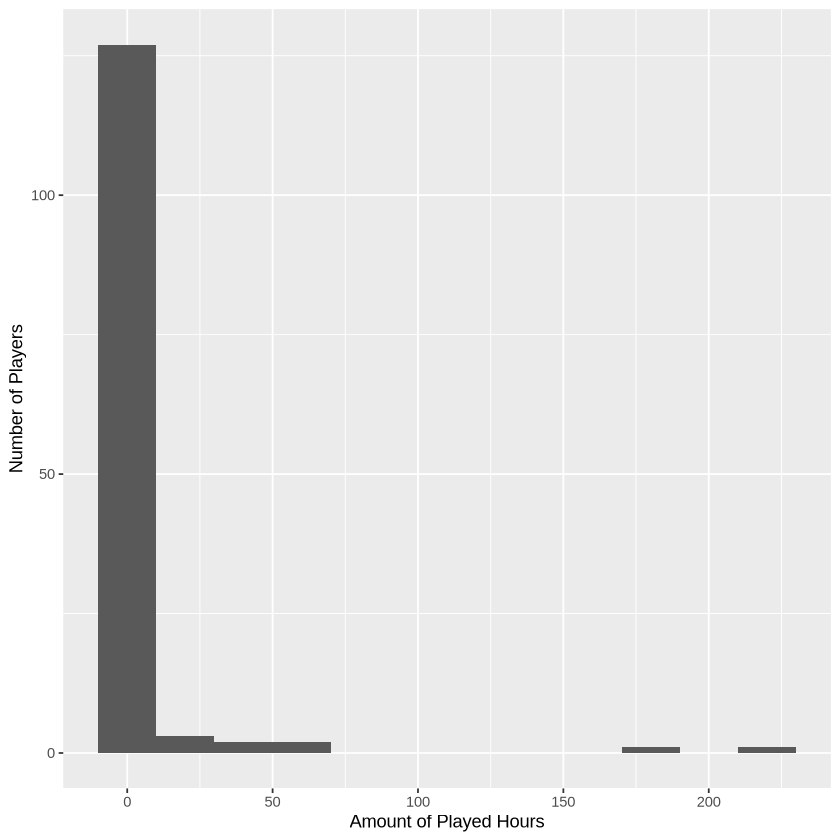

In [65]:
#Removing Outliers
set.seed(2024)
outlier_plot <- training |>
                ggplot(aes(x = played_hours)) +
                geom_histogram(binwidth = 20) +
                xlab("Amount of Played Hours") +
                ylab("Number of Players")
outlier_plot

experience,played_hours,age
<dbl>,<dbl>,<dbl>
4,0.0,17
1,0.0,17
3,0.0,19
1,0.0,21
1,0.1,17
4,0.0,22


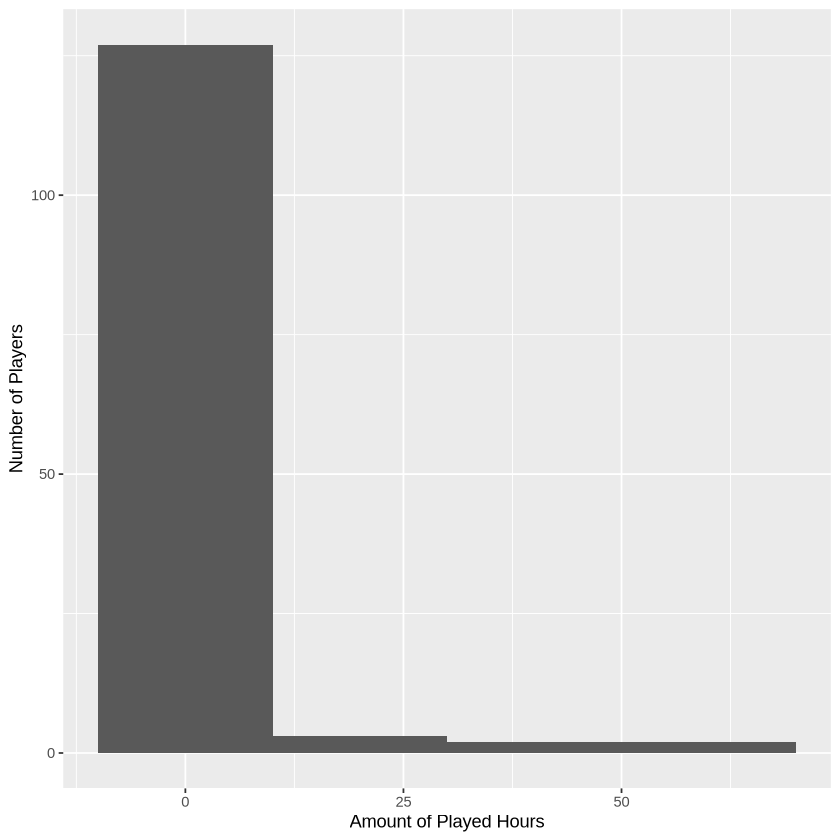

In [66]:
set.seed(2024)

training_final <- training |>
        filter(played_hours < 100)
head(training_final)

without_ot_plot <- training_final |>
                ggplot(aes(x = played_hours)) +
                geom_histogram(binwidth = 20) +
                xlab("Amount of Played Hours") +
                ylab("Number of Players")
without_ot_plot

In [67]:
#knn-classification model 
set.seed(2024)

knn_recipe <- recipe(played_hours ~., data = training_final) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("regression") 

vfold <- vfold_cv(training, v = 5, strata = played_hours) 

wf <- workflow() |>
        add_recipe(knn_recipe) |>
        add_model(knn_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 30, by = 3 )) 

knn_results <- wf |>
                tune_grid(resamples = vfold, grid = gridvals) |>
                collect_metrics() |>
                filter(.metric == "rmse") 
(knn_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,27.42767,5,10.053027,Preprocessor1_Model01
4,rmse,standard,22.23846,5,8.559086,Preprocessor1_Model02
7,rmse,standard,21.55767,5,8.652285,Preprocessor1_Model03
10,rmse,standard,21.41533,5,8.730275,Preprocessor1_Model04
13,rmse,standard,21.63424,5,8.629192,Preprocessor1_Model05
16,rmse,standard,21.27489,5,8.718886,Preprocessor1_Model06
19,rmse,standard,20.61865,5,8.877821,Preprocessor1_Model07
22,rmse,standard,20.04835,5,9.008645,Preprocessor1_Model08
25,rmse,standard,19.84922,5,9.055790,Preprocessor1_Model09


 Named list()
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

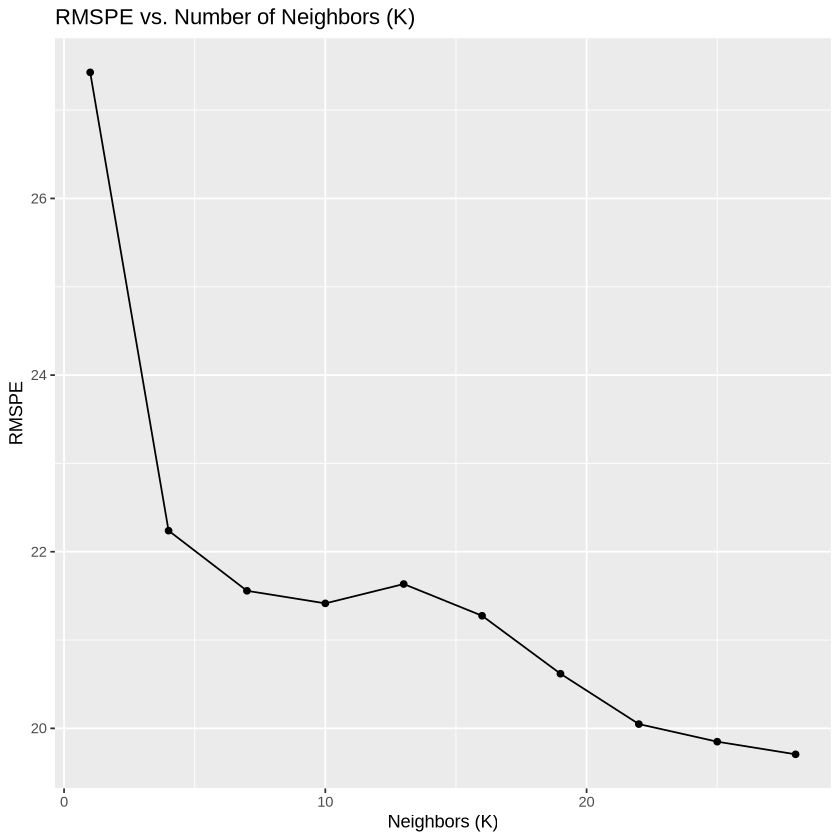

In [68]:
set.seed(2024)
neighbors_plot <- knn_results |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                xlab("Neighbors (K)") +
                ylab("RMSPE") +
                ggtitle("RMSPE vs. Number of Neighbors (K)")
                theme(element_text(size = 18))
neighbors_plot

In [69]:
set.seed(2024)
knn_best <- knn_results |>
            slice_min(mean, n = 1)
knn_best

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
28,rmse,standard,19.70617,5,9.089821,Preprocessor1_Model10


In [86]:
set.seed(2024)
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 28) |>
            set_engine("kknn") |>
            set_mode("regression") 
best_fit <- workflow() |>
            add_recipe(knn_recipe) |>
            add_model(best_spec) |>
            fit(data = training_final) 
knn_rmspe <- best_fit |>
            predict(testing) |>
            bind_cols(testing) |>
            metrics(truth = played_hours, estimate = .pred) |>
            filter(.metric == "rmse") |>
            select(.estimate)
knn_rmspe

.estimate
<dbl>
34.61918


#### Linear Regression Model

In [73]:
set.seed(2024)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

lm_recipe <- recipe(played_hours~., data = training_final) 

lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(data = training_final)

lm_rmpse <- lm_fit |>
    predict(testing) |>
    bind_cols(testing) |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(.estimate)
lm_rmpse

.estimate
<dbl>
34.36562


#### Discussion

#### References